<center>
    <p align="center">
        <img src="https://logodownload.org/wp-content/uploads/2017/09/mackenzie-logo-3.png" style="height: 7ch;"><br>
        <h1 align="center">Computer Systems Undergradute Thesis</h1>
        <h2 align="center">Quantitative Analysis of the Impact of Image Pre-Processing on the Accuracy of Computer Vision Models Trained to Identify Dermatological Skin Diseases</a>
        <h4 align="center">Gabriel Mitelman Tkacz</a>
        </h4>
    </p>
</center>

<hr>

In [1]:
import re
import tomllib
from functools import partial
from itertools import permutations
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pynimbar import loading_animation

from util import (
	ColorSpaceTransform,
	DenoiseTransform,
	EqualizationTransform,
	NormalizeTransform,
	evaluate_model,
	get_model_data,
)

In [2]:
with open("parameters.toml") as f:
	parameters = tomllib.loads(f.read())

loading_handler = partial(loading_animation, break_on_error=True, verbose_errors=True, time_it_live=True)

alpha = chr(0x03B1)

pd.set_option("display.max_rows", 500)

pprint(parameters)

{'PREPROCESS': {'colorspace': {'source_space': 'RGB', 'target_space': 'HSV'},
                'denoise': {'search_window_size': 19,
                            'template_window_size': 5},
                'normalize': {'mean': 0.4, 'std': 0.2}},
 'TRAINING': {'batch_size': 128,
              'diseased_skin_path': './dataset/diseased/',
              'healthy_skin_path': './dataset/healthy/',
              'learning_rate': 0.0001,
              'num_epochs': 3,
              'num_workers': 12,
              'pin_memory': True,
              'precision_threshold': 0.8,
              'resize_dim': 128,
              'shuffle': True,
              'training_dataset_ratio': 0.8}}


In [3]:
preprocesses = (
	ColorSpaceTransform(**parameters["PREPROCESS"]["colorspace"]),
	DenoiseTransform(**parameters["PREPROCESS"]["denoise"]),
	EqualizationTransform(),
	NormalizeTransform(**parameters["PREPROCESS"]["normalize"]),
)

preprocess_combinations = {i: permutations(preprocesses, i) for i in range(2, len(preprocesses) + 1)}

preprocess_labels = {s.__class__.__name__: re.sub(r"[^A-Z]", "", s.__class__.__name__)[:-1] for s in preprocesses}
preprocess_labels

{'ColorSpaceTransform': 'CS',
 'DenoiseTransform': 'D',
 'EqualizationTransform': 'E',
 'NormalizeTransform': 'N'}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
training_ratio = parameters["TRAINING"]["training_dataset_ratio"]
testing_ratio = validation_ratio = round(1 - training_ratio, 1) / 2

print(f"Training ratio: {training_ratio * 100}%")
print(f"Testing ratio: {testing_ratio * 100}%")
print(f"Validation ratio: {validation_ratio * 100}%")

seed = 47
print(f"\nSeed: {seed}")

Training ratio: 80.0%
Testing ratio: 10.0%
Validation ratio: 10.0%

Seed: 47


## Class 0 Model: Images with no pre-processing

In [6]:
(
	base_train_loader,
	base_test_loader,
	base_validation_loader,
) = get_model_data(
	training_ratio=training_ratio,
	testing_ratio=testing_ratio,
	validation_ratio=validation_ratio,
	seed=seed,
)

base_precision, base_confusion_matrix, base_training_time = evaluate_model(
	device, base_train_loader, base_test_loader, base_validation_loader,
)

print(f"Base precision: {base_precision * 100:.1f}%")

if base_precision < parameters["TRAINING"]["precision_threshold"]:
	raise ValueError("The base model did not meet the precision threshold.")

base_confusion_matrix

Epoch 1/3, Train Loss: 0.0460, Train Accuracy: 94.1%, Validation Loss: 0.0305, Validation Accuracy: 95.8%
Epoch 2/3, Train Loss: 0.0255, Train Accuracy: 96.7%, Validation Loss: 0.0196, Validation Accuracy: 97.8%
Epoch 3/3, Train Loss: 0.0209, Train Accuracy: 97.4%, Validation Loss: 0.0141, Validation Accuracy: 98.1%
Total training duration: 0.4 minutes
Test Accuracy of the Binary Classification Model: 98.3%
Base precision: 98.3%


{'TP': 383, 'TN': 600, 'FP': 12, 'FN': 5}

## Class 1 Models: Images with only one pre-process

### Class 1.1 Models: Normalizing the image

In [7]:
(
	normalize_train_loader,
	normalize_test_loader,
	normalize_validation_loader,
) = get_model_data(
	[NormalizeTransform(**parameters["PREPROCESS"]["normalize"])],
	training_ratio=training_ratio,
	testing_ratio=testing_ratio,
	validation_ratio=validation_ratio,
	seed=seed,
)

normalize_precision, normalize_confusion_matrix, normalize_training_time = evaluate_model(
	device, normalize_train_loader, normalize_test_loader, normalize_validation_loader,
)

normalize_precision_diff = normalize_precision - base_precision

print(f"\n\nNormalized precision: {normalize_precision * 100:.1f}%")
print(
	f"That is an {'upgrade' if normalize_precision_diff > 0 else 'downgrade'} of {normalize_precision_diff * 100:.1f}%.",
)

Epoch 1/3, Train Loss: 0.0437, Train Accuracy: 94.4%, Validation Loss: 0.0221, Validation Accuracy: 97.1%
Epoch 2/3, Train Loss: 0.0252, Train Accuracy: 96.9%, Validation Loss: 0.0168, Validation Accuracy: 98.0%
Epoch 3/3, Train Loss: 0.0193, Train Accuracy: 97.6%, Validation Loss: 0.0153, Validation Accuracy: 98.0%
Total training duration: 0.4 minutes
Test Accuracy of the Binary Classification Model: 98.1%


Normalized precision: 98.1%
That is an downgrade of -0.2%.


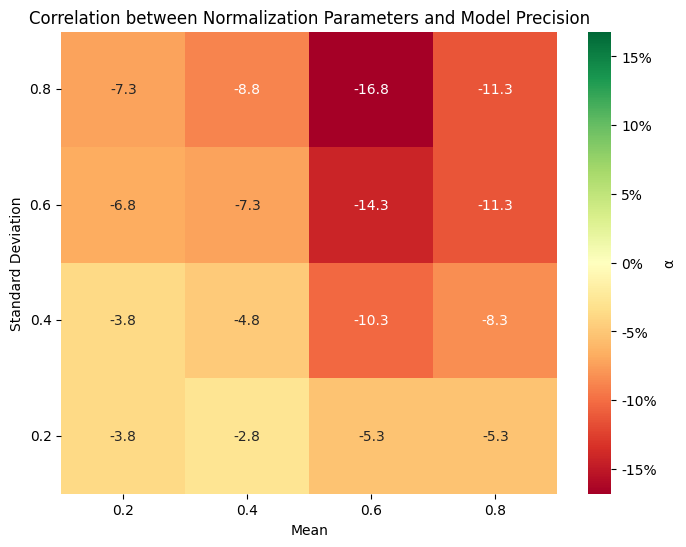

In [8]:
df = pd.read_json("./params/normalize.json")

df["precision"] = df["precision"] - base_precision

pivot_table = df.pivot(index="std", columns="mean", values="precision")

pivot_table = pivot_table.sort_index().sort_index(axis=1).iloc[::-1]

pivot_table_pct = pivot_table * 100

vabs = max(abs(pivot_table_pct.min().min()), abs(pivot_table_pct.max().max()))

plt.figure(figsize=(8, 6))

sns.heatmap(
	pivot_table_pct,
	annot=True,
	fmt=".1f",
	cmap="RdYlGn",
	cbar_kws={"label": alpha, "format": "%.0f%%"},
	vmin=-vabs,
	vmax=vabs,
)

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.gca().set_xticklabels([f"{x:.1f}" for x in pivot_table_pct.columns])
plt.gca().set_yticklabels([f"{y:.1f}" for y in pivot_table_pct.index])

plt.title("Correlation between Normalization Parameters and Model Precision")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")

plt.show()

### Class 1.2 Models: Denoising the image

In [9]:
(
	denoise_train_loader,
	denoise_test_loader,
	denoise_validation_loader,
) = get_model_data(
	[DenoiseTransform(**parameters["PREPROCESS"]["denoise"])],
	training_ratio=training_ratio,
	testing_ratio=testing_ratio,
	validation_ratio=validation_ratio,
	seed=seed,
)

denoise_precision, denoise_confusion_matrix, denoise_training_time = evaluate_model(
	device, denoise_train_loader, denoise_test_loader, denoise_validation_loader,
)

denoise_precision_diff = denoise_precision - base_precision

print(f"\n\nDenoised precision: {denoise_precision * 100:.1f}%")
print(f"That is an {'upgrade' if denoise_precision_diff > 0 else 'downgrade'} of {denoise_precision_diff * 100:.1f}%.")

Epoch 1/3, Train Loss: 0.0495, Train Accuracy: 93.8%, Validation Loss: 0.0264, Validation Accuracy: 96.7%
Epoch 2/3, Train Loss: 0.0272, Train Accuracy: 96.4%, Validation Loss: 0.0216, Validation Accuracy: 97.4%
Epoch 3/3, Train Loss: 0.0211, Train Accuracy: 97.3%, Validation Loss: 0.0191, Validation Accuracy: 97.3%
Total training duration: 1.6 minutes
Test Accuracy of the Binary Classification Model: 98.5%


Denoised precision: 98.5%
That is an upgrade of 0.2%.


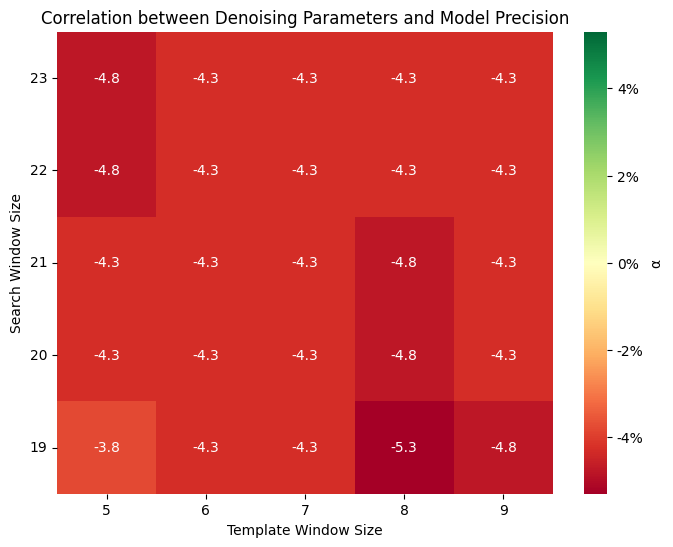

In [10]:
df = pd.read_json("./params/denoise.json")

df["precision"] = df["precision"] - base_precision

pivot_table = df.pivot(index="search_window_size", columns="template_window_size", values="precision")

pivot_table = pivot_table.sort_index().sort_index(axis=1).iloc[::-1]

pivot_table_pct = pivot_table * 100

vabs = max(abs(pivot_table_pct.min().min()), abs(pivot_table_pct.max().max()))

plt.figure(figsize=(8, 6))

sns.heatmap(
	pivot_table_pct,
	annot=True,
	fmt=".1f",
	cmap="RdYlGn",
	cbar_kws={"label": alpha, "format": "%.0f%%"},
	vmin=-vabs,
	vmax=vabs,
)

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.gca().set_xticklabels([f"{x:.0f}" for x in pivot_table_pct.columns])
plt.gca().set_yticklabels([f"{y:.0f}" for y in pivot_table_pct.index])

plt.title("Correlation between Denoising Parameters and Model Precision")
plt.xlabel("Template Window Size")
plt.ylabel("Search Window Size")

plt.show()

### Class 1.3 Models: Equalizing the image

In [11]:
(
	equalized_train_loader,
	equalized_test_loader,
	equalized_validation_loader,
) = get_model_data(
	[EqualizationTransform()],
	training_ratio=training_ratio,
	testing_ratio=testing_ratio,
	validation_ratio=validation_ratio,
	seed=seed,
)

equalized_precision, equalized_confusion_matrix, equalized_training_time = evaluate_model(
	device, equalized_train_loader, equalized_test_loader, equalized_validation_loader,
)

equalized_precision_diff = equalized_precision - base_precision

print(f"\n\nEqualized precision: {equalized_precision * 100:.1f}%")
print(
	f"That is an {'upgrade' if equalized_precision_diff > 0 else 'downgrade'} of {equalized_precision_diff * 100:.1f}%.",
)

Epoch 1/3, Train Loss: 0.0387, Train Accuracy: 95.1%, Validation Loss: 0.0312, Validation Accuracy: 95.8%
Epoch 2/3, Train Loss: 0.0184, Train Accuracy: 97.6%, Validation Loss: 0.0178, Validation Accuracy: 97.3%
Epoch 3/3, Train Loss: 0.0123, Train Accuracy: 98.4%, Validation Loss: 0.0138, Validation Accuracy: 98.0%
Total training duration: 0.4 minutes
Test Accuracy of the Binary Classification Model: 98.0%


Equalized precision: 98.0%
That is an downgrade of -0.3%.


### Class 1.4 Models: Changing the colorspace

In [12]:
(
	colorspace_train_loader,
	colorspace_test_loader,
	colorspace_validation_loader,
) = get_model_data(
	[ColorSpaceTransform(**parameters["PREPROCESS"]["colorspace"])],
	training_ratio=training_ratio,
	testing_ratio=testing_ratio,
	validation_ratio=validation_ratio,
	seed=seed,
)

colorspace_precision, colorspace_confusion_matrix, colorspace_training_time = evaluate_model(
	device, colorspace_train_loader, colorspace_test_loader, colorspace_validation_loader,
)

colorspace_precision_diff = colorspace_precision - base_precision

print(f"\n\nColorspaced precision: {colorspace_precision * 100:.1f}%")
print(
	f"That is an {'upgrade' if colorspace_precision_diff > 0 else 'downgrade'} of {colorspace_precision_diff * 100:.1f}%.",
)

Epoch 1/3, Train Loss: 0.0528, Train Accuracy: 93.4%, Validation Loss: 0.0442, Validation Accuracy: 94.0%
Epoch 2/3, Train Loss: 0.0300, Train Accuracy: 96.2%, Validation Loss: 0.0385, Validation Accuracy: 94.8%
Epoch 3/3, Train Loss: 0.0232, Train Accuracy: 97.0%, Validation Loss: 0.0240, Validation Accuracy: 96.8%
Total training duration: 0.4 minutes
Test Accuracy of the Binary Classification Model: 97.4%


Colorspaced precision: 97.4%
That is an downgrade of -0.9%.


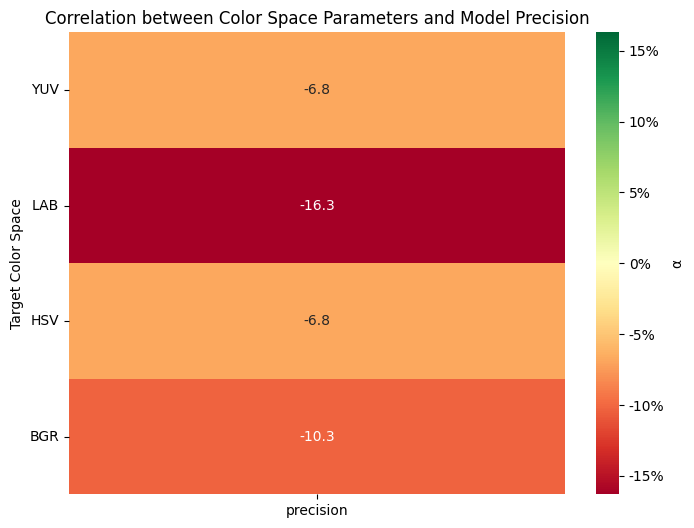

In [13]:
df = pd.read_json("./params/colorspace.json")

df["precision"] = df["precision"] - base_precision

pivot_table = df.set_index("target_space")

pivot_table = pivot_table.sort_index().sort_index(axis=1).iloc[::-1]

pivot_table_pct = pivot_table * 100

vabs = max(abs(pivot_table_pct.min().min()), abs(pivot_table_pct.max().max()))

plt.figure(figsize=(8, 6))

sns.heatmap(
	pivot_table_pct,
	annot=True,
	fmt=".1f",
	cmap="RdYlGn",
	cbar_kws={"label": alpha, "format": "%.0f%%"},
	vmin=-vabs,
	vmax=vabs,
)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.title("Correlation between Color Space Parameters and Model Precision")
plt.ylabel("Target Color Space")

plt.show()

In [14]:
class1_precisions = {
	NormalizeTransform.__name__: (normalize_precision, normalize_training_time),
	EqualizationTransform.__name__: (equalized_precision, equalized_training_time),
	DenoiseTransform.__name__: (denoise_precision, denoise_training_time),
	ColorSpaceTransform.__name__: (colorspace_precision, colorspace_training_time),
}

class1_df_data = [
	{
		"transform_1": k.split(", ")[0],
		"precision": v[0],
		alpha: v[0] - base_precision,
		"training_time": v[1],
		"training_time_ratio": v[1] / base_training_time,
	}
	for k, v in class1_precisions.items()
]
class1_df = pd.DataFrame(class1_df_data).sort_values(alpha, ascending=False).reset_index(drop=True)
class1_df.transform_1 = class1_df.transform_1.apply(lambda x: preprocess_labels[x])
class1_df

,transform_1,precision,α,training_time,training_time_ratio
0,D,0.985,0.002,95.722102,4.098070
1,N,0.981,-0.002,22.395504,0.958800
2,E,0.980,-0.003,21.995007,0.941654
3,CS,0.974,-0.009,23.520648,1.006970


## Class 2 Models: Images with two pre-processes

In [15]:
class2_precisions = {}

for idx, combination in enumerate(preprocess_combinations[2]):
	(
		class2_train_loader,
		class2_test_loader,
		class2_validation_loader,
	) = get_model_data(
		combination,
		training_ratio=training_ratio,
		testing_ratio=testing_ratio,
		validation_ratio=validation_ratio,
		seed=seed,
	)

	curr_precision, curr_confusion_matrix, curr_training_time = evaluate_model(
		device, class2_train_loader, class2_test_loader, class2_validation_loader, verbose=False,
	)

	uuid = ", ".join([str(t.__class__.__name__) for t in combination])

	class2_precisions[uuid] = (curr_precision, curr_training_time)

	curr_precision_diff = curr_precision - base_precision

	print(f"\n\nClass 2.{idx + 1} {uuid} precision: {curr_precision * 100:.1f}%")
	print(f"That is an {'upgrade' if curr_precision_diff > 0 else 'downgrade'} of {curr_precision_diff * 100:.1f}%.")



Class 2.1 ColorSpaceTransform, DenoiseTransform precision: 97.6%
That is an downgrade of -0.7%.


Class 2.2 ColorSpaceTransform, EqualizationTransform precision: 97.3%
That is an downgrade of -1.0%.


Class 2.3 ColorSpaceTransform, NormalizeTransform precision: 97.6%
That is an downgrade of -0.7%.


Class 2.4 DenoiseTransform, ColorSpaceTransform precision: 97.0%
That is an downgrade of -1.3%.


Class 2.5 DenoiseTransform, EqualizationTransform precision: 97.9%
That is an downgrade of -0.4%.


Class 2.6 DenoiseTransform, NormalizeTransform precision: 98.6%
That is an upgrade of 0.3%.


Class 2.7 EqualizationTransform, ColorSpaceTransform precision: 97.3%
That is an downgrade of -1.0%.


Class 2.8 EqualizationTransform, DenoiseTransform precision: 97.1%
That is an downgrade of -1.2%.


Class 2.9 EqualizationTransform, NormalizeTransform precision: 98.1%
That is an downgrade of -0.2%.


Class 2.10 NormalizeTransform, ColorSpaceTransform precision: 89.5%
That is an downgrade of -8.8%.



In [16]:
class2_df_data = [
	{
		"transform_1": k.split(", ")[0],
		"transform_2": k.split(", ")[1],
		"precision": v[0],
		alpha: v[0] - base_precision,
		"training_time": v[1],
		"training_time_ratio": v[1] / base_training_time,
	}
	for k, v in class2_precisions.items()
]
class2_df = pd.DataFrame(class2_df_data).sort_values(alpha, ascending=False).reset_index(drop=True)
class2_df.transform_1 = class2_df.transform_1.apply(lambda x: preprocess_labels[x])
class2_df.transform_2 = class2_df.transform_2.apply(lambda x: preprocess_labels[x])
class2_df

,transform_1,transform_2,precision,α,training_time,training_time_ratio
0,D,N,0.986,0.003,92.465374,3.958643
1,E,N,0.981,-0.002,23.090688,0.988562
2,D,E,0.979,-0.004,91.883833,3.933745
3,CS,D,0.976,-0.007,94.293958,4.036928
4,CS,N,0.976,-0.007,22.651637,0.969766
5,CS,E,0.973,-0.010,23.697781,1.014553
6,E,CS,0.973,-0.010,23.321859,0.998459
7,E,D,0.971,-0.012,93.589694,4.006777
8,D,CS,0.970,-0.013,92.420614,3.956726
9,N,D,0.913,-0.070,93.325608,3.995471


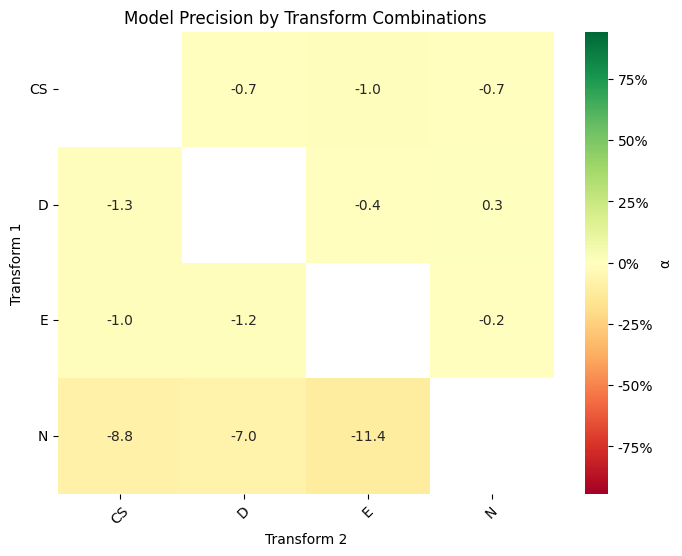

In [17]:
grouped = class2_df.groupby(["transform_1", "transform_2"]).mean()
grouped[alpha] *= 100

vabs = max(abs(grouped.min().min()), abs(grouped.max().max()))

pivot = grouped[alpha].unstack()

plt.figure(figsize=(8, 6))
sns.heatmap(
	pivot, annot=True, fmt=".1f", cmap="RdYlGn", cbar_kws={"label": alpha, "format": "%.0f%%"}, vmax=vabs, vmin=-vabs,
)
plt.title("Model Precision by Transform Combinations")
plt.ylabel("Transform 1")
plt.xlabel("Transform 2")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Class 3 Models: Images with three pre-processes

In [18]:
class3_precisions = {}

for idx, combination in enumerate(preprocess_combinations[3]):
	(
		class3_train_loader,
		class3_test_loader,
		class3_validation_loader,
	) = get_model_data(
		combination,
		training_ratio=training_ratio,
		testing_ratio=testing_ratio,
		validation_ratio=validation_ratio,
		seed=seed,
	)

	curr_precision, curr_confusion_matrix, curr_training_time = evaluate_model(
		device, class3_train_loader, class3_test_loader, class3_validation_loader, verbose=False,
	)

	uuid = "→".join([str(t.__class__.__name__) for t in combination])

	class3_precisions[uuid] = (curr_precision, curr_training_time)

	curr_precision_diff = curr_precision - base_precision

	print(f"\n\nClass 3.{idx + 1} {uuid} precision: {curr_precision * 100:.1f}%")
	print(f"That is an {'upgrade' if curr_precision_diff > 0 else 'downgrade'} of {curr_precision_diff * 100:.1f}%.")



Class 3.1 ColorSpaceTransform→DenoiseTransform→EqualizationTransform precision: 96.4%
That is an downgrade of -1.9%.


Class 3.2 ColorSpaceTransform→DenoiseTransform→NormalizeTransform precision: 97.0%
That is an downgrade of -1.3%.


Class 3.3 ColorSpaceTransform→EqualizationTransform→DenoiseTransform precision: 96.5%
That is an downgrade of -1.8%.


Class 3.4 ColorSpaceTransform→EqualizationTransform→NormalizeTransform precision: 97.2%
That is an downgrade of -1.1%.


Class 3.5 ColorSpaceTransform→NormalizeTransform→DenoiseTransform precision: 92.1%
That is an downgrade of -6.2%.


Class 3.6 ColorSpaceTransform→NormalizeTransform→EqualizationTransform precision: 94.3%
That is an downgrade of -4.0%.


Class 3.7 DenoiseTransform→ColorSpaceTransform→EqualizationTransform precision: 96.6%
That is an downgrade of -1.7%.


Class 3.8 DenoiseTransform→ColorSpaceTransform→NormalizeTransform precision: 96.4%
That is an downgrade of -1.9%.


Class 3.9 DenoiseTransform→EqualizationTransform→Co

In [20]:
class3_df_data = [
	{
		"transform_1": k.split("→")[0],
		"transform_2": k.split("→")[1],
		"transform_3": k.split("→")[2],
		"precision": v[0],
		alpha: v[0] - base_precision,
		"training_time": v[1],
		"training_time_ratio": v[1] / base_training_time,
	}
	for k, v in class3_precisions.items()
]
class3_df = pd.DataFrame(class3_df_data).sort_values(alpha, ascending=False).reset_index(drop=True)
class3_df.transform_1 = class3_df.transform_1.apply(lambda x: preprocess_labels[x])
class3_df.transform_2 = class3_df.transform_2.apply(lambda x: preprocess_labels[x])
class3_df.transform_3 = class3_df.transform_3.apply(lambda x: preprocess_labels[x])
class3_df

,transform_1,transform_2,transform_3,precision,α,training_time,training_time_ratio
0,D,E,N,0.979,-0.004,94.649325,4.052142
1,E,CS,D,0.975,-0.008,93.482097,4.002171
2,E,CS,N,0.973,-0.010,22.633773,0.969001
3,CS,E,N,0.972,-0.011,22.703638,0.971992
4,D,E,CS,0.972,-0.011,95.105701,4.071681
5,CS,D,N,0.970,-0.013,93.158054,3.988298
6,E,D,CS,0.969,-0.014,94.539323,4.047433
7,E,D,N,0.968,-0.015,93.126550,3.986949
8,D,CS,E,0.966,-0.017,94.572371,4.048848
9,CS,E,D,0.965,-0.018,94.811569,4.059088


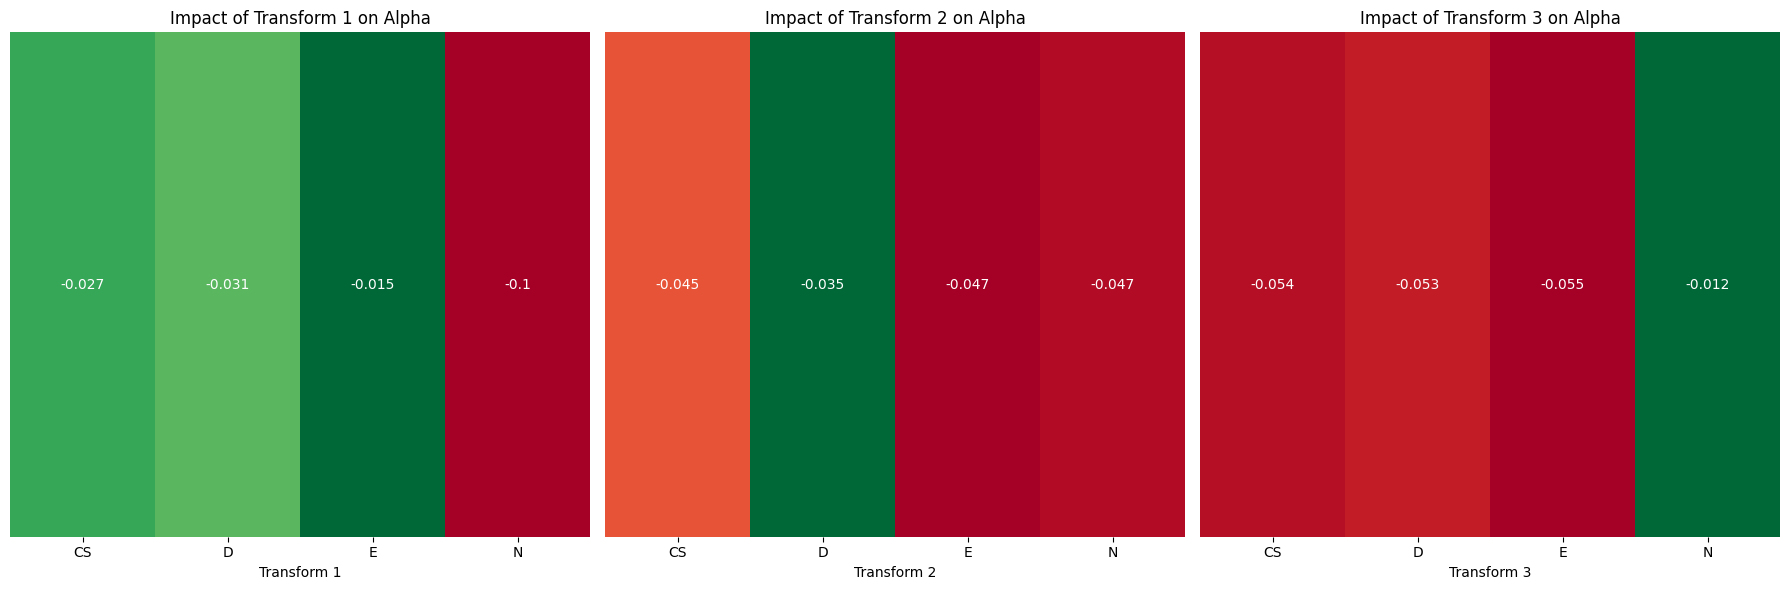

In [21]:
order = preprocess_labels.values()

# Set up the matplotlib figure
plt.figure(figsize=(18, 6))

# Heatmap for Transform 1 vs Alpha
plt.subplot(1, 3, 1)
# Calculate mean alpha for each category in transform_1
pivot_t1 = class3_df.pivot_table(values=alpha, index="transform_1", aggfunc="mean").reindex(order)
# Transpose for heatmap
pivot_t1 = pivot_t1.T
sns.heatmap(pivot_t1, annot=True, cmap="RdYlGn", cbar=False)
plt.title("Impact of Transform 1 on Alpha")
plt.xlabel("Transform 1")
plt.yticks([])  # Hide y-axis labels

# Heatmap for Transform 2 vs Alpha
plt.subplot(1, 3, 2)
# Calculate mean alpha for each category in transform_2
pivot_t2 = class3_df.pivot_table(values=alpha, index="transform_2", aggfunc="mean").reindex(order)
# Transpose for heatmap
pivot_t2 = pivot_t2.T
sns.heatmap(pivot_t2, annot=True, cmap="RdYlGn", cbar=False)
plt.title("Impact of Transform 2 on Alpha")
plt.xlabel("Transform 2")
plt.yticks([])  # Hide y-axis labels

# Heatmap for Transform 3 vs Alpha
plt.subplot(1, 3, 3)
# Calculate mean alpha for each category in transform_3
pivot_t3 = class3_df.pivot_table(values=alpha, index="transform_3", aggfunc="mean").reindex(order)
# Transpose for heatmap
pivot_t3 = pivot_t3.T
sns.heatmap(pivot_t3, annot=True, cmap="RdYlGn", cbar=False)
plt.title("Impact of Transform 3 on Alpha")
plt.xlabel("Transform 3")
plt.yticks([])  # Hide y-axis labels

plt.tight_layout()
plt.show()

# Additional Heatmaps for Combined Transforms

# Heatmap for Transform 1 and Transform 2
# plt.figure(figsize=(12, 6))
# pivot_t1_t2 = class3_df.pivot_table(values=alpha, index='transform_1', columns='transform_2', aggfunc='mean').reindex(index=order, columns=order)
# sns.heatmap(pivot_t1_t2, annot=True, cmap='RdYlGn', linewidths=0.5, linecolor='gray')
# plt.title('Impact of Transform 1 and Transform 2 on Alpha')
# plt.xlabel('Transform 2')
# plt.ylabel('Transform 1')
# plt.show()

# # Heatmap for Transform 1 and Transform 3
# plt.figure(figsize=(12, 6))
# pivot_t1_t3 = class3_df.pivot_table(values=alpha, index='transform_1', columns='transform_3', aggfunc='mean').reindex(index=order, columns=order)
# sns.heatmap(pivot_t1_t3, annot=True, cmap='RdYlGn', linewidths=0.5, linecolor='gray')
# plt.title('Impact of Transform 1 and Transform 3 on Alpha')
# plt.xlabel('Transform 3')
# plt.ylabel('Transform 1')
# plt.show()

# # Heatmap for Transform 2 and Transform 3
# plt.figure(figsize=(12, 6))
# pivot_t2_t3 = class3_df.pivot_table(values=alpha, index='transform_2', columns='transform_3', aggfunc='mean').reindex(index=order, columns=order)
# sns.heatmap(pivot_t2_t3, annot=True, cmap='RdYlGn', linewidths=0.5, linecolor='gray')
# plt.title('Impact of Transform 2 and Transform 3 on Alpha')
# plt.xlabel('Transform 3')
# plt.ylabel('Transform 2')
# plt.show()

## Class 4 Models: Images with four pre-processes

In [22]:
class4_precisions = {}

for idx, combination in enumerate(preprocess_combinations[4]):
	(
		class4_train_loader,
		class4_test_loader,
		class4_validation_loader,
	) = get_model_data(
		combination,
		training_ratio=training_ratio,
		testing_ratio=testing_ratio,
		validation_ratio=validation_ratio,
		seed=seed,
	)

	curr_precision, curr_confusion_matrix, curr_training_time = evaluate_model(
		device, class4_train_loader, class4_test_loader, class4_validation_loader, verbose=False,
	)

	uuid = "➔".join([str(t.__class__.__name__) for t in combination])

	class4_precisions[uuid] = (curr_precision, curr_training_time)

	curr_precision_diff = curr_precision - base_precision

	print(f"\n\nClass 4.{idx + 1} {uuid} precision: {curr_precision * 100:.1f}%")
	print(f"That is an {'upgrade' if curr_precision_diff > 0 else 'downgrade'} of {curr_precision_diff * 100:.1f}%.")



Class 4.1 ColorSpaceTransform➔DenoiseTransform➔EqualizationTransform➔NormalizeTransform precision: 96.1%
That is an downgrade of -2.2%.


Class 4.2 ColorSpaceTransform➔DenoiseTransform➔NormalizeTransform➔EqualizationTransform precision: 93.6%
That is an downgrade of -4.7%.


Class 4.3 ColorSpaceTransform➔EqualizationTransform➔DenoiseTransform➔NormalizeTransform precision: 96.7%
That is an downgrade of -1.6%.


Class 4.4 ColorSpaceTransform➔EqualizationTransform➔NormalizeTransform➔DenoiseTransform precision: 89.5%
That is an downgrade of -8.8%.


Class 4.5 ColorSpaceTransform➔NormalizeTransform➔DenoiseTransform➔EqualizationTransform precision: 92.8%
That is an downgrade of -5.5%.


Class 4.6 ColorSpaceTransform➔NormalizeTransform➔EqualizationTransform➔DenoiseTransform precision: 92.5%
That is an downgrade of -5.8%.


Class 4.7 DenoiseTransform➔ColorSpaceTransform➔EqualizationTransform➔NormalizeTransform precision: 97.0%
That is an downgrade of -1.3%.


Class 4.8 DenoiseTransform➔Color

In [23]:
class4_df_data = [
	{
		"transform_1": k.split("➔")[0],
		"transform_2": k.split("➔")[1],
		"transform_3": k.split("➔")[2],
		"transform_4": k.split("➔")[3],
		"precision": v[0],
		alpha: v[0] - base_precision,
		"training_time": v[1],
		"training_time_ratio": v[1] / base_training_time,
	}
	for k, v in class4_precisions.items()
]
class4_df = pd.DataFrame(class4_df_data).sort_values(alpha, ascending=False).reset_index(drop=True)
class4_df.transform_1 = class4_df.transform_1.apply(lambda x: preprocess_labels[x])
class4_df.transform_2 = class4_df.transform_2.apply(lambda x: preprocess_labels[x])
class4_df.transform_3 = class4_df.transform_3.apply(lambda x: preprocess_labels[x])
class4_df.transform_4 = class4_df.transform_4.apply(lambda x: preprocess_labels[x])
class4_df

,transform_1,transform_2,transform_3,transform_4,precision,α,training_time,training_time_ratio
0,E,CS,D,N,0.977,-0.006,97.623141,4.179458
1,D,E,CS,N,0.973,-0.010,96.220746,4.119418
2,E,D,CS,N,0.973,-0.010,96.578312,4.134726
3,D,CS,E,N,0.970,-0.013,95.519514,4.089397
4,CS,E,D,N,0.967,-0.016,95.909629,4.106098
5,E,CS,N,D,0.963,-0.020,99.809377,4.273055
6,CS,D,E,N,0.961,-0.022,98.899752,4.234112
7,E,N,D,CS,0.959,-0.024,98.498089,4.216916
8,E,N,CS,D,0.954,-0.029,99.333391,4.252677
9,E,D,N,CS,0.954,-0.029,96.004925,4.110178


In [29]:
analysis_df = (
	pd.concat([class1_df, class2_df, class3_df, class4_df], axis=0)
	.reset_index(drop=True)
	.fillna("-")[["transform_1", "transform_2", "transform_3", "transform_4", alpha, "training_time_ratio"]]
)
analysis_df[alpha] *= 100
analysis_df[f"w{alpha}"] = analysis_df.apply(
	lambda row: row[alpha] / row["training_time_ratio"] if row[alpha] > 0 else row[alpha] * row["training_time_ratio"],
	axis=1,
)
analysis_df.head(100).sort_values(f"w{alpha}", ascending=False)

,transform_1,transform_2,transform_3,transform_4,α,training_time_ratio,wα
4,D,N,-,-,0.3,3.958643,0.075784
0,D,-,-,-,0.2,4.098070,0.048803
1,N,-,-,-,-0.2,0.958800,-0.191760
5,E,N,-,-,-0.2,0.988562,-0.197712
2,E,-,-,-,-0.3,0.941654,-0.282496
8,CS,N,-,-,-0.7,0.969766,-0.678836
3,CS,-,-,-,-0.9,1.006970,-0.906273
18,E,CS,N,-,-1.0,0.969001,-0.969001
10,E,CS,-,-,-1.0,0.998459,-0.998459
9,CS,E,-,-,-1.0,1.014553,-1.014553


In [ ]:
from datetime import datetime
from pathlib import Path

import dill

dill.dump_session(Path("checkpoints/" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + "_globalsave.pkl"))
# filename = 'globalsave.pkl'
# dill.load_session(filename)